# Deformation with Extracted Mesh

We use Trex as the example to show how to use ARAP for mesh-guided deformation.

We will use Open3D to perform ARAP

In [31]:
import os, sys
import open3d as o3d
import numpy as np

sys.path.append('../')
from pcd_editing import write_pth, get_pcd
from mesh_editing import mesh_fix
from mesh2pcd import mesh2pcd

## 1. Prepare Point Cloud and Mesh

In [3]:
save_dir = '../../checkpoints/nerfsynth_sdf/trex/'
pth_file = save_dir + '160000_net_ray_marching.pth'
get_pcd(pth_file, save_dir + '160000_pcd.ply')

In [49]:
!cd ../../run; python test_ft.py --config ../dev_scripts/spidr/trex.ini --run_mode=sdf --marching_cube

ARAP requires the mesh to be a single connected component. We might need to fix the mesh.

`pymeshfix` provides a simple meshfix function to merge disconnected components and close holes.

In [6]:
mesh_fix(save_dir + '160000_mesh.obj') # --> 160000_mesh_fix.obj

## 2. Deform Mesh with ARAP

In [7]:
mesh = o3d.io.read_triangle_mesh(save_dir + '160000_mesh_fix.obj')

You can use `draw_geometries_with_vertex_selection` to select the vertices to be deformed.

No worry, in this example, we will provide the vertex selection for you.

In [ ]:
print('Original Mesh')
# R = mesh.get_rotation_matrix_from_xyz((0, np.pi, 0))
mesh.compute_vertex_normals()
o3d.visualization.draw_geometries_with_vertex_selection([mesh])

In [8]:
# leg + base
static_pnt = np.array([
    [-0.92, 0.02, -0.31],
    [0.92, 0.01, -0.31],
    [0.47, 0.80, -0.31],
    [-0.48, -0.79, -0.31],
    [0.80, -0.47, -0.31],
    [-0.45, 0.80, -0.31],
    [-0.01, 0.93, -0.32],
    [-0.20, 0.03, 0.62],
    [0.22, 0.04, 0.62],
    [-0.25, 0.05, -0.04],
    [0.17, 0.05, -0.07],
])
# tail
tail_pnt = np.array([
    [-0.00, 1.58, 0.37],
    [-0.02, 1.27, 0.28],
    [-0.02, 0.90, 0.30],
])
# head
head_pnt = np.array([
    [-0.00, -1.41, 0.90],
    [-0.00, -1.03, 1.06],
    [0.12, -1.28, 0.82],
    [-0.13, -1.28, 0.82],
    [0.10, -1.11, 0.66],
    [-0.11, -1.07, 0.67],
])

In [9]:
vertices = np.asarray(mesh.vertices)

In [14]:
def get_closest_pnt_idx(pnt, vertices):
    dist = np.linalg.norm(vertices[..., None, :] - pnt[None, ...], axis=-1)
    return np.argmin(dist, axis=0)

In [17]:
static_ids = get_closest_pnt_idx(static_pnt, vertices)
tail_ids = get_closest_pnt_idx(tail_pnt, vertices)
head_ids = get_closest_pnt_idx(head_pnt, vertices)

In [19]:
static_pos = np.array([vertices[id] for id in static_ids])
# define deformation
rot_center = np.array([0, -0.02, 0.58])

tail_pos = np.array([vertices[id] for id in tail_ids])
R = o3d.geometry.get_rotation_matrix_from_xyz(np.array([-28/180*np.pi, 0, 10/180*np.pi]))
tail_pos_r = (R @ (tail_pos - rot_center).T).T + rot_center

head_pos = np.array([vertices[id] for id in head_ids])
R = o3d.geometry.get_rotation_matrix_from_xyz(np.array([-15/180*np.pi, 0, 0]))
head_pos_r = (R @ (head_pos - rot_center).T).T + rot_center

In [27]:
# ARAP
constraint_ids = o3d.utility.IntVector(np.concatenate([static_ids, tail_ids, head_ids], 0).tolist())
constraint_pos = o3d.utility.Vector3dVector(np.concatenate([static_pos, tail_pos_r, head_pos_r], 0))

with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
            mesh_prime = mesh.deform_as_rigid_as_possible(
                constraint_ids, constraint_pos,
                #   energy=o3d.geometry.DeformAsRigidAsPossibleEnergy.Smoothed,
                max_iter=60)

[Open3D DEBUG] [DeformAsRigidAsPossible] setting up S'
[Open3D DEBUG] [DeformAsRigidAsPossible] done setting up S'
[Open3D DEBUG] [DeformAsRigidAsPossible] setting up system matrix L
[Open3D DEBUG] [DeformAsRigidAsPossible] done setting up system matrix L
[Open3D DEBUG] [DeformAsRigidAsPossible] setting up sparse solver
[Open3D DEBUG] [DeformAsRigidAsPossible] done setting up sparse solver
[Open3D DEBUG] [DeformAsRigidAsPossible] iter=0, energy=2.131675e-01
[Open3D DEBUG] [DeformAsRigidAsPossible] iter=1, energy=5.102009e-02
[Open3D DEBUG] [DeformAsRigidAsPossible] iter=2, energy=2.601864e-02
[Open3D DEBUG] [DeformAsRigidAsPossible] iter=3, energy=1.679037e-02
[Open3D DEBUG] [DeformAsRigidAsPossible] iter=4, energy=1.237554e-02
[Open3D DEBUG] [DeformAsRigidAsPossible] iter=5, energy=9.787330e-03
[Open3D DEBUG] [DeformAsRigidAsPossible] iter=6, energy=8.080551e-03
[Open3D DEBUG] [DeformAsRigidAsPossible] iter=7, energy=6.891443e-03
[Open3D DEBUG] [DeformAsRigidAsPossible] iter=8, energy

In [29]:
os.environ['DISPLAY'] = ':0'
print('Deformed Mesh')
mesh_prime.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh_prime, mesh])

Deformed Mesh


Note to make sure the two meshes have the same vertex order. We write both meshes with open3d.

In [30]:
# save
o3d.io.write_triangle_mesh(save_dir + '160000_mesh_fix_arap.obj', mesh_prime)
o3d.io.write_triangle_mesh(save_dir + '160000_mesh_fix_o3d.obj', mesh)

[Open3D WARNING] Write OBJ can not include triangle normals.


True

## 3. Transfer Deformation to Point Cloud & Ckpt

In [33]:
mesh2pcd(save_dir + '160000_mesh_fix_o3d.obj', save_dir + '160000_mesh_fix_arap.obj', save_dir + '160000_pcd.ply', save_dir + '160000_pcd_deform.ply')

read triangle mesh: V=188490, F=377156
read pcd: V=170454


In [34]:
pth_new_file = save_dir + '160010_net_ray_marching.pth'
write_pth(pth_file, pth_new_file, save_dir + '160000_pcd_deform.ply')

## 4. Render Deformed Scene

In [48]:
!cd ../../run; python test_ft.py --config ../dev_scripts/spidr/trex.ini --run_mode=sdf --split=test --resume_iter 160010 --test_end_id 5

The illumination updates require to re-bake the depth maps from the light sources (since the object geometry has changed):

In [47]:
!cd ../../run; python test_ft.py --config ../dev_scripts/spidr/trex.ini --run_mode=sdf --bake_light --down_sample=0.5 --resume_iter=160010 --SR=60

Then we can render the deformed scene with illumination updates:

In [46]:
!cd ../../run; python test_ft.py --config ../dev_scripts/spidr/trex.ini --run_mode=lighting --split=test --resume_iter 160010 --test_end_id 5

Text(0.5, 1.0, 'PBR')

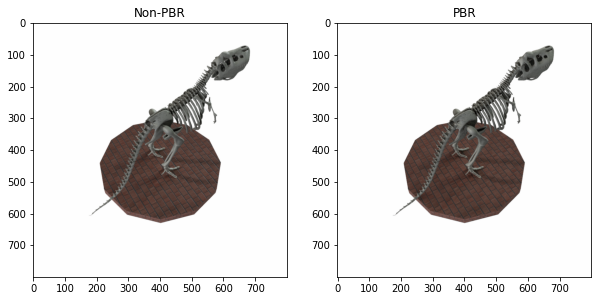

In [45]:
import matplotlib.pyplot as plt

non_pbr = '../../checkpoints/nerfsynth_sdf/trex/test_160010/images/step-0002-coarse_raycolor.png'
pbr = '../../checkpoints/nerfsynth_sdf/trex/test_160010/images/step-0002-brdf_combine_raycolor.png'

non_pbr = plt.imread(non_pbr)
pbr = plt.imread(pbr)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(non_pbr)
plt.title('Non-PBR')
plt.subplot(1,2,2)
plt.imshow(pbr)
plt.title('PBR')